In [71]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import glob
from keras.models import Sequential
from keras.layers import Dense,Conv1D,Conv2D,MaxPooling2D,Flatten,AveragePooling2D,Input,BatchNormalization,AveragePooling1D
from keras.optimizers import RMSprop

from utils.dataloader import read_edf_to_raw, calculate_neg_pos

In [72]:
def create_model_article():
    # Model creation
    model = Sequential()
    # model.add(Input(shape=(23,25600,1)))

    model.add(Conv1D(4, 5, activation='relu', input_shape=(25600, 23), name='conv1'))
    model.add(BatchNormalization(name='batch1'))
    model.add(AveragePooling1D(pool_size=2, strides=2, name='pool1'))
    # output ~(12800,4)

    model.add(Conv1D(4, 6, activation='relu', name='conv2'))
    model.add(BatchNormalization(name='batch2'))
    model.add(AveragePooling1D(pool_size=4, strides=1,name='pool2'))
    # output ~(12800,4)

    model.add(Conv1D(10, 4, activation='relu', name='conv3'))
    model.add(BatchNormalization(name='batch3'))
    model.add(AveragePooling1D(pool_size=2, strides=2, name='pool3'))
    # output ~(6400,4)

    model.add(Conv1D(10, 4, activation='relu', name='conv4'))
    model.add(BatchNormalization(name='batch4'))
    model.add(AveragePooling1D(pool_size=2, strides=4, name='pool4'))
    # output ~(1200,4)

    model.add(Conv1D(15, 2, activation='relu', name='conv5'))
    model.add(BatchNormalization(name='batch5'))
    model.add(AveragePooling1D(pool_size=2, strides=4, name='pool5'))

    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [82]:
def create_model_customized():
    # Model creation
    model = Sequential()
    # model.add(Input(shape=(23,25600,1)))

    model.add(Conv2D(16, 3, activation='relu', padding='same', input_shape=(25600, 23, 1), name='conv1'))
    model.add(BatchNormalization(name='batch1'))
    model.add(MaxPooling2D(pool_size=(32,2), name='pool1'))

    model.add(Conv2D(8, 5, activation='relu', padding='same', name='conv2'))
    model.add(BatchNormalization(name='batch2'))
    model.add(MaxPooling2D(pool_size=(16,2), name='pool2'))

    model.add(Conv2D(4, 7, activation='relu', padding='same', name='conv3'))
    model.add(BatchNormalization(name='batch3'))
    model.add(MaxPooling2D(pool_size=(8,2), name='pool3'))

    model.add(Conv2D(2, 3, activation='relu',  padding='same', name='conv7'))
    model.add(BatchNormalization(name='batch7'))
    model.add(MaxPooling2D(pool_size=(4,2), name='pool4'))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [83]:
model = create_model_customized()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 25600, 23, 16)     160       
                                                                 
 batch1 (BatchNormalization)  (None, 25600, 23, 16)    64        
                                                                 
 pool1 (MaxPooling2D)        (None, 800, 11, 16)       0         
                                                                 
 conv2 (Conv2D)              (None, 800, 11, 8)        3208      
                                                                 
 batch2 (BatchNormalization)  (None, 800, 11, 8)       32        
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 5, 8)          0         
                                                                 
 conv3 (Conv2D)              (None, 50, 5, 4)         

In [84]:
opt = keras.optimizers.RMSprop(learning_rate=0.011)
# Create the loss function object using the wrapper function above
# spec_loss = specificity_loss_wrapper()
model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(), 
            optimizer=opt, 
            metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5), tf.keras.metrics.SensitivityAtSpecificity(0.5)])

In [76]:
NEW_DATASET_PATH = "/media/guisoares/guisoares-ext-hdd/Datasets/chb-mit-segments/2"

train_files = glob.glob(os.path.join(NEW_DATASET_PATH,'train',"*.npz"))
test_files = glob.glob(os.path.join(NEW_DATASET_PATH,'test',"*.npz"))

print("Training files:")
print(train_files)
print("Testing files:")
print(test_files)

Training files:
['/media/guisoares/guisoares-ext-hdd/Datasets/chb-mit-segments/2/train/chb02_segments.npz', '/media/guisoares/guisoares-ext-hdd/Datasets/chb-mit-segments/2/train/chb03_segments.npz', '/media/guisoares/guisoares-ext-hdd/Datasets/chb-mit-segments/2/train/chb05_segments.npz']
Testing files:
['/media/guisoares/guisoares-ext-hdd/Datasets/chb-mit-segments/2/test/chb01_segments.npz']


In [77]:
# Load test arrays to memory
x_test = []
y_test = []
for file in test_files:
    test_arrays = np.load(file)
    x_test.append(test_arrays['arr_0'])
    y_test.append(test_arrays['arr_1'])

x_test = np.array(x_test)
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3]))
x_test = np.swapaxes(x_test, 1, 2)

y_test = np.array(y_test)
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], -1))

In [78]:
def calculate_neg_pos(y):
    unique, counts = np.unique(y, return_counts=True)
    dic = dict(zip(unique, counts))
    neg = dic[0]
    pos = dic[1]
    return neg, pos

neg_test, pos_test = calculate_neg_pos(y_test)
print(f"Negatives: {neg_test}, Positives: {pos_test}")

Negatives: 25, Positives: 11


In [85]:
# callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta=0.05)

epochs = 50
for epoch in range(epochs):
    for file in train_files:

        # y = np.load('signals/chb01/labels.npy')
        # x = np.load('signals/chb01/signals.npy') 

        arrays = np.load(file)
        x_train = arrays['arr_0']
        y_train = arrays['arr_1']
        x_train = np.swapaxes(x_train, 1, 2) #swap axis: N,23,25600 -> N,25600, 23
        # x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, shuffle=True)

        print(f"Epoch: {epoch+1} ", end = "")
        unique, counts = np.unique(y_train, return_counts=True)
        print(f"Train :{dict(zip(unique, counts))} ", end="")

        history = model.fit(x_train, y_train, batch_size=1, epochs=1, validation_data=(x_test,y_test), verbose=2)

        if history.history['binary_accuracy'][0] > 0.99:
            break
    if history.history['binary_accuracy'][0] > 0.99:
        break
    
        # train_metrics = model.train_on_batch(x_train, y_train, return_dict=True)
        # test_metrics = model.test_on_batch(x_test, y_test, return_dict=True)

        # print(train_metrics, test_metrics)



Epoch: 1 Train :{0: 11, 1: 5} 16/16 - 10s - loss: 1.4920 - binary_accuracy: 0.5625 - sensitivity_at_specificity_4: 0.6000 - val_loss: 0.6578 - val_binary_accuracy: 0.6944 - val_sensitivity_at_specificity_4: 0.0000e+00 - 10s/epoch - 614ms/step
Epoch: 1 Train :{0: 28, 1: 12} 40/40 - 13s - loss: 0.7405 - binary_accuracy: 0.6750 - sensitivity_at_specificity_4: 0.4167 - val_loss: 0.6164 - val_binary_accuracy: 0.6944 - val_sensitivity_at_specificity_4: 0.0000e+00 - 13s/epoch - 327ms/step
Epoch: 1 Train :{0: 23, 1: 10} 33/33 - 12s - loss: 0.7128 - binary_accuracy: 0.6970 - sensitivity_at_specificity_4: 0.5000 - val_loss: 0.6405 - val_binary_accuracy: 0.6944 - val_sensitivity_at_specificity_4: 0.0000e+00 - 12s/epoch - 361ms/step
Epoch: 2 Train :{0: 11, 1: 5} 16/16 - 7s - loss: 0.7665 - binary_accuracy: 0.6875 - sensitivity_at_specificity_4: 0.2000 - val_loss: 0.6386 - val_binary_accuracy: 0.6944 - val_sensitivity_at_specificity_4: 0.0000e+00 - 7s/epoch - 458ms/step
Epoch: 2 Train :{0: 28, 1: 1

KeyboardInterrupt: 

In [ ]:
history.history.keys

[1.0]

In [ ]:
y_pred = model.predict(x_train)
print(y_pred)
y_pred = np.where(y_pred < 0.5, 0, 1)
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

1/1 [==============================] - 0s 489ms/step
[[0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]
 [0.3029069]]
{0: 20}
{0: 14, 1: 6}


[1]


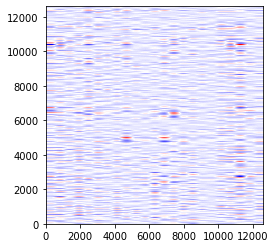

In [ ]:
import matplotlib.pyplot as plt
ind= np.argwhere(y_test == 1)[0,:]
print(y_test[ind[0]])
plt.imshow(x_test[ind[0]], extent=(0,12600,0, 12600), cmap='seismic')
plt.show()

[0]


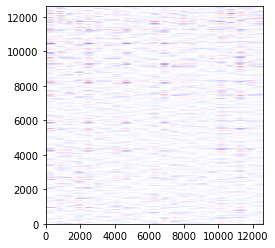

In [ ]:
i = 1
print(y_train[i])
plt.imshow(x_train[i], extent=(0,12600,0, 12600), cmap='seismic')
plt.show()

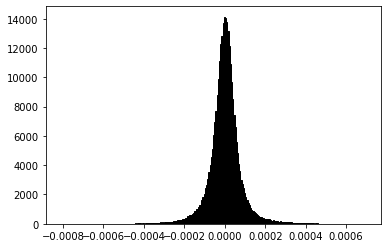

In [ ]:
plt.hist(x_train[ind[0]].ravel(), bins=256, fc='k', ec='k')
plt.show()

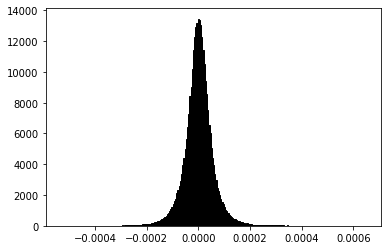

In [ ]:
plt.hist(x_train[0].ravel(), bins=256, fc='k', ec='k')
plt.show()